# Creating data tables from images of manuscript field notes


### This script uses the bounding box coordinates to generate a pandas DataFrame

##### Bouding box notes:
Bounding boxes are made up of 8 coordinates that identify points along the x and y axes and create a box. The coordinates are as follows: `[0,1, 2,3, 4,5, 6,7] == [x1,y1, x2,y2, x3,y3, x4,y4]`. This information helps to create the dictionaries of x_coords and y_coords used thorughout the script.  


## 1. Setup 

- Import libraries and data
- Setup vars needed later
- Plot boxes (just helpful to see)

In [342]:
# Import libs and data
import json
import pandas as pd
import itertools
import collections
import statistics
import numpy as np

f = open("HP_out/sea19631966196800natib_0007.handprint-microsoft.json")
data = json.load(f)

In [343]:
#list of lines
lines = []
for d in data['analyzeResult']['readResults'][0]['lines']:
    lines.append(d)

In [344]:
#dict of all x_coords of lines
x_coords_lines = {}
for ln in lines:
    temp_list = []
    temp_list.append([ln['boundingBox'][0], ln['boundingBox'][2], ln['boundingBox'][4], ln['boundingBox'][6]])
    text = ln['text']
    x_coords_lines[text] = temp_list[0]

In [345]:
#dict of y_coords of lines
y_coords_lines = {}
for ln in lines:
    temp_list = []
    temp_list.append([ln['boundingBox'][1], ln['boundingBox'][3], ln['boundingBox'][5], ln['boundingBox'][7]])
    text = ln['text']
    y_coords_lines[text] = temp_list[0]

### Plot bounding boxes for lines

Just for fun!

In [346]:
lines_df = pd.DataFrame(columns = ["label", "xy", "width", "height"])
for l in lines:
    label = l['text']
    xy = l['boundingBox'][0], l['boundingBox'][1]
    width = l['boundingBox'][2] - l['boundingBox'][0]
    height = l['boundingBox'][7] - l['boundingBox'][1]
    temp_dict = {'label':label, 'xy':xy, 'width':width, 'height':height}
    lines_df = lines_df.append(temp_dict, ignore_index=True)

In [347]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

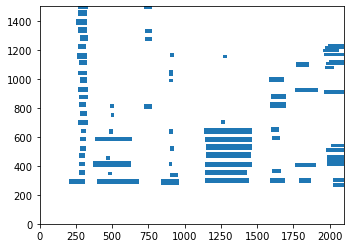

In [348]:
#define Matplotlib figure and axis
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
plt.xlim([0,2100])
plt.ylim([0,1500])

patches = []

for i, j in lines_df.iterrows():
    xy = j['xy'] 
    w = j['width']
    h = j['height']
    patches.append(Rectangle(xy,w,h))

ax.add_collection(PatchCollection(patches))

#display plot
plt.savefig("008_lines.png")
plt.show()

## 2. Function to create lists of columns 

**General Method:**
Use dict of x_coords to see which boxes overlap along the x-axis. Each group pf overlaps forms one column. Use minimum values to move along the x-axis and assign a dict of "leftovers" for the words that are left to be sorted. 


**Notes:**
Using words doesn't really work, because identifying the columns based on words means that multi-word columns are separated into on column per word. 

Bascially, will it be easier in post-processing & human validataion to condense many columns into fewer or for lines that missed the delimiter, separate values into multiple columns?

TBH, the lines aren't * *that* * bad. I think sticking with line level (not words) is going to be easier at scale. Both will require humans to edit and validate the locations in addition to the value/text. 

In [349]:
#create column function
#var = dict of x coordinates

def create_column(var):
    ##CREATE COLUMN
    #get minimum x_coords
    m_list = min(var.values())
    m = min(m_list)
    
    #l = largest x coord of smallest
    l = max(m_list)
    
    #col is boxes with min xcoord is between m and l
    global col
    col = {}
    for c in var.items():
        if m <= min(c[1]) <= l:
            col[c[0]] = c[1]
    
    
    ##IDENTIFY LEFTOVERS
    #remaining_boxes = all boxes that remain with min xcoords larger than l
    global leftovers
    leftovers = {}
    for q in var.items():
        if l <= min(q[1]):
            leftovers[q[0]] = q[1]
    
    
    #CALCULATE NEW WORD COUNT
    global word_count 
    word_count = len(leftovers)        
            
    return col, var, word_count

In [350]:
#setup
leftovers = x_coords_lines
word_count = len(leftovers)
column_lists = []

#create columns
while word_count > 0:
    create_column(leftovers)
    column_lists.append(col)

## 3. Create rows and make DataFrame

**General Strategy:**

Since the OCR is pretty good about IDing the entry numbers (`column_lists[0]`), we can use those to initiate y coordintes for rows. For each value in each column, see if the box overlaps with any value in the `column_lists[0]` column along the y-axis to form a row. 

In [351]:
#initialize DF
df = pd.DataFrame(column_lists[0].keys(), columns = ["col_1"])

#for each dict in list of columns
for h, i in enumerate(column_lists):
    #for number and row in dataframe
    for index, rows in df.iterrows():
        #for key in dictionary (of column)
        for j in i.keys():
            #if the average y_coord for this key(box) is between the min and max y_coords for the key(box) in col_1(df)
            if min(y_coords_lines[rows[0]]) <= statistics.mean(y_coords_lines[j]) <= max(y_coords_lines[rows[0]]):
                #add this key to the dataframe at position: current row of df, current column in column_lists
                df.at[index, h] = j

In [352]:
df = df.drop(0, axis = 1)
df

,col_1,1,2,3,4,5,6,7,8,9,10,11
0,2345,SterNA fusCATA,NaN,21 July,8 24' N 1760 30 W,199.5,light,すさけis 3×コード,5,SkEl,Hoff 61,NaN
1,46,NaN,NaN,NaN,00 28' N 1760 29' W,206,NaN,NaN,NaN,NaN,Huber 908,NaN
2,47,Fregata Ariel,NaN,NaN,00 24' N 176º 30 W,NaN,very light,+Estes 7x 3 -T,1S,NaN,NaN,843
3,48,NaN,NaN,NaN,0º 24'N 176' 30'00,NaN,NaN,1.4. 108 14 mm,Nomilf,=,BALcomb 106,NaN
4,49,NaN,NaN,NaN,"6º 23'N 176"" 30'W",NaN,NaN,L. OUum 3 Min DE,BS,5 kč/,PEARSON,33
5,50,SterNA fuSCALA,NaN,NaN,OP / 20'N 1760 30'W,189,NaN,NaN,NaN,NaN,Huber 848,NaN
6,51,NaN,NaN,NaN,"10"" ""17'N 176º 31'W",194,NaN,NaN,NaN,NaN,NaN,849
7,. 52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8 56
8,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,~,851
9,54,NaN,NaN,NaN,NaN,2 10.9,NaN,NaN,NaN,NaN,NaN,852


In [353]:
#save to dir
df.to_csv("sea19631966196800natib_0007.csv", index = False)